In [1]:
import base64
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Preprocessing Functions

In [3]:
def decode_base64(item):
    return base64.b64decode(item.encode()).decode('utf-8')

In [4]:
def decode_human_ai_hash(df):
    df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    df = df.applymap(lambda x: x.replace('\xa0', '').strip() if isinstance(x, str) else x)
    df['hash'] = df['hash'].apply(decode_base64)
    df['REQID_ex'] = df['hash'].str.split('__________').str[0]
    df['author'] = df['hash'].str.split('__________').str[-1]
    df.drop(columns = ['hash'], inplace = True)

    nan_summary = df.isnull().sum()
    print("Number of NaN values in each column:\n", nan_summary)
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            majority_value = df[column].mode()[0]
            df[column].fillna(majority_value, inplace = True)
    return df

In [5]:
participants = ['p1', 'p2', 'p3', 'p4']

human_assessed_requirements = [pd.read_excel(f'./{i}_human_evaluation/tasks_b_and_c/task_c.xlsx') for i in participants]
human_assessed_requirements = [decode_human_ai_hash(df) for df in human_assessed_requirements]

Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?    0
This requirement is well-structured according to the ISO-29248 recommended syntax.                                 0
The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.         0
REQID_ex                                                                                                           0
author                                                                                                             0
dtype: int64
Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human 

In [6]:
likert_label2id = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly Agree': 5
}

ai_human_label2id = {
    'AI': 0,
    'HUMAN': 1
}

likert_id2label = {v: k for k, v in zip(likert_label2id.keys(), likert_label2id.values())}
ai_human_id2label = {v: k for k, v in zip(ai_human_label2id.keys(), ai_human_label2id.values())}

In [7]:
human_assessed_requirements_concated = pd.concat(human_assessed_requirements, axis = 0)
human_ai, syntax_quality, keyword_quality = human_assessed_requirements_concated.columns[1:-2]

In [8]:
# # mapping labels to id mapping
human_assessed_requirements_concated[human_ai] = human_assessed_requirements_concated[human_ai].map(ai_human_label2id)
human_assessed_requirements_concated['author'] = human_assessed_requirements_concated['author'].map(ai_human_label2id)
human_assessed_requirements_concated[syntax_quality] = human_assessed_requirements_concated[syntax_quality].map(likert_label2id)
human_assessed_requirements_concated[keyword_quality] = human_assessed_requirements_concated[keyword_quality].map(likert_label2id)
human_assessed_requirements_concated

requirement  \
0   The program shall respond to start of transcei...   
1   The system shall provide the ability to manage...   
2   Visual and acoustic warnings to the driver abo...   
3   The product shall generate a Comparative Marke...   
4   "Due to non-disclosure agreements, this requir...   
..                                                ...   
63  If ifr Conditions change by 500ft or reset tim...   
64  80% of end users should have the capability to...   
65  The product shall be available 99% of the time...   
66  "Due to non-disclosure agreements, this requir...   
67  The product shall include FT (fault avoiding) ...   

    Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?  \
0                                                   1                                                                 
1                                                   0                                                                 
2                                                   1                                                                 
3                                                   0                                                                 
4                                                   1                                                                 
..                                                ...                                                                 
63                                                  0                                                                 
64                                                  0                                                                 
65                                                  0                                                                 
66                                                  1                                                                 
67                                                  0                                                                 

    This requirement is well-structured according to the ISO-29248 recommended syntax.  \
0                                                   4                                    
1                                                   2                                    
2                                                   2                                    
3                                                   5                                    
4                                                   5                                    
..                                                ...                                    
63                                                  1                                    
64                                                  5                                    
65                                                  2                                    
66                                                  5                                    
67                                                  5                                    

    The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.  \
0                                                   5                                                            
1                                                   2                                                            
2                                                   4                                                            
3                                                   5                                                            
4                                                   5                                                            
..                                                ...                                                            
63                                               

# Descriptive Statistics (not shown on the paper)

In [9]:
# Ploting Likert percentage frequencies 
import plot_likert

def prepare_data_for_likert_precentage_scale_plot(df, likert_columns, filter_distro):
    select_ai = filter_distro[0]
    select_hu = filter_distro[1]
    syntax_quality = likert_columns[0]
    keyword_quality = likert_columns[1]

    # Filter HUMAN
    q1_hu_authored_syntax = df[df['author'] == ai_human_label2id[select_hu]][syntax_quality]
    q2_hu_authored_skeyword = df[df['author'] == ai_human_label2id[select_hu]][keyword_quality]
    
    # Filter AI
    q1_ai_authored_syntax = df[df['author'] == ai_human_label2id[select_ai]][syntax_quality]
    q2_ai_authored_skeyword = df[df['author'] == ai_human_label2id[select_ai]][keyword_quality]

    hu_ai_syntax = {
        'Human': [likert_id2label[i] for i in q1_hu_authored_syntax],
        'ReqBrain': [likert_id2label[i] for i in q1_ai_authored_syntax]
    }
    hu_ai_keyword = {
        'Human': [likert_id2label[i] for i in q2_hu_authored_skeyword],
        'ReqBrain': [likert_id2label[i] for i in q2_ai_authored_skeyword]
        }
    hu_ai_syntax_df = pd.DataFrame(hu_ai_syntax)
    hu_ai_keyword_df = pd.DataFrame(hu_ai_keyword)
    
    return hu_ai_syntax_df, hu_ai_keyword_df

In [10]:
human_ai_q1, human_ai_q2 = prepare_data_for_likert_precentage_scale_plot(human_assessed_requirements_concated,
                                                                         likert_columns = [syntax_quality, keyword_quality],
                                                                         filter_distro = ['AI', 'HUMAN'])

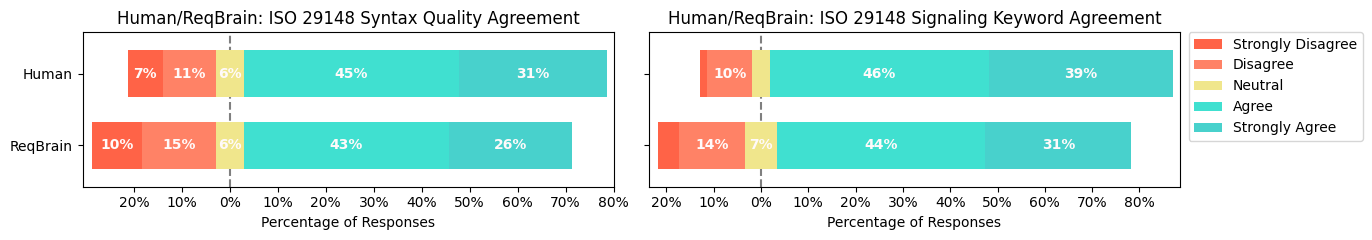

In [11]:
plot_likert.__internal__.BAR_LABEL_FORMAT = "%.0f"

scale = likert_label2id.keys()
my_color_scheme = [
    plot_likert.colors.TRANSPARENT,
    '#FF6347',  # Tomato (strong disagreement)
    '#FF8266',  # Lighter tomato
    '#F0E68C',  # Khaki (neutral color matching both)
    '#40E0D0',  # Turquoise
    '#48D1CC'   # Medium Turquoise (strong agreement)
]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 2.5))
ax1.set_title("Human/ReqBrain: ISO 29148 Syntax Quality Agreement")
plot_likert.plot_likert(human_ai_q1, scale, plot_percentage = True,
                        bar_labels = True, 
                        bar_labels_color = "snow", 
                        colors = my_color_scheme,
                        ax = ax1,
                        legend = 0,
                        width = 0.65)

ax2.set_title("Human/ReqBrain: ISO 29148 Signaling Keyword Agreement")
plot_likert.plot_likert(human_ai_q2, scale, plot_percentage = True, 
                        bar_labels = True, 
                        bar_labels_color="snow", 
                        colors = my_color_scheme,
                        ax = ax2,
                        legend = 0,
                        width = 0.65)

ax2.set_yticklabels([])
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (1.1456, .88))
plt.tight_layout()
plt.savefig('./raw_human_rating_plots_not/task_c_raw_ratings.png', dpi = 300)
plt.show()

# Quality Check 1

## **Question:**  
Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?

---

## **Hypotheses:**

- **Null Hypothesis (H₀):**  
Humans cannot reliably distinguish the difference between human-authored and AI-generated software requirements; their identification accuracy is no better than random guessing (50%).

- **Alternative Hypothesis (H₁):**  
Humans can reliably distinguish between human-authored and AI-generated software requirements, achieving an identification accuracy significantly above random guessing (more than 50%).

---
## **Statistics Report:** 
A Chi-square test was conducted to determine whether the ReqBrain generated and Human authored requirments are distinguishable for human raters. The null hypothesis stated that human accuracy would not exceed random guessing (50%) meaning ReqBrain and Human authored  requirments are of the same quality.

The test involved 272 requirements, with known authorship as either human or generated by ReqBrain, and 272 corresponding ratings by humans who attempted to identify the authorship category for each requirement. The expected frequencies were [[64, 72], [64, 72]]. The results indicated no statistically significant difference in identification accuracy, χ²(1, N = 544) = 0.015, p = .903. Human precision in distinguishing human-authored from ReqBrain-authored requirements was 0.507, with a 95% confidence interval of [0.448, 0.566]. These findings suggest that humans' ability to distinguish between human-written and ReqBrain-generated requirements did not significantly exceed random guessing.<br><br><br>


**Table 1.** Evaluation Criteria for Identifying Human vs. AI-Generated Requirements

| **Criteria**                 | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| **Attention to Detail**       | Examine the quality, clarity, and realism of the requirement.                   |
| **Coherence and Consistency** | Consider whether the requirement makes logical sense and fits within the context. |
| **Detection of Hallucinations** | Look for any information that seems fabricated, exaggerated, or irrelevant.    |
| **Practicality**              | Evaluate if the requirement is realistic, implementable, or overly complex/vague. |


# Code

In [12]:
labels = ai_human_label2id.keys()
y_true = human_assessed_requirements_concated['author']
y_pred = human_assessed_requirements_concated[human_ai]

In [13]:
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from scipy.stats import chi2_contingency, chi2


confusion_matrix = confusion_matrix(y_true, y_pred)
chi2_stat, p, dof, expected = chi2_contingency(confusion_matrix)
print(f"P-Value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Chi-Square Test Statistic: {chi2_stat}")
print(f"Expected Frequencies:\n {expected}")

precision = precision_score(y_true, y_pred)
print(f"\nHuman precision in differentiating human vs. ReqBrain-authored requirements: {precision:.3f}")

n = len(y_true)
confidence = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
margin_of_error = z_score * np.sqrt((precision * (1 - precision)) / n)
confidence_interval = (precision - margin_of_error, precision + margin_of_error)
print(f"{confidence * 100}% Confidence Human precision in differentiating human vs. ReqBrain-authored requirements: {confidence_interval}")

P-Value: 0.9033123088324688
Degrees of freedom: 1
Chi-Square Test Statistic: 0.014756944444444444
Expected Frequencies:
 [[64. 72.]
 [64. 72.]]

Human precision in differentiating human vs. ReqBrain-authored requirements: 0.507
95.0% Confidence Human precision in differentiating human vs. ReqBrain-authored requirements: (0.447530039574786, 0.5663588493141029)


# **Why Mann-Whitney U-test and Vargha and Delaney’s A?**
The non-parametric Mann-Whitney U-test was selected due to the potential for non-normal data distributions and the presence of outliers, which are common in software engineering experiments involving randomized algorithms [1]. Additionally, Vargha and Delaney’s A was chosen as the effect size measure, as it provides a robust, non-parametric assessment of stochastic superiority between groups, making it well-suited for data that may not adhere to normality [2].

### **References:**
[1] A. Arcuri and L. Briand, "A Practical Guide for Using Statistical Tests to Assess Randomized Algorithms in Software Engineering," in Proceedings of the 33rd International Conference on Software Engineering (ICSE'11), Honolulu, HI, USA, 2011, pp. 1-10.<br>

[2] N. L. Leech and A. J. Onwuegbuzie, "A Call for Greater Use of Nonparametric Statistics," presented at the Annual Meeting of the Mid-South Educational Research Association, Chattanooga, TN, USA, Nov. 2002.

---

## **Vargha and Delaney’s A Resutls:**
- **Vargha and Delaney’s A**: 0.54

### **Vargha Interpretation Cheet Sheet:**
* A = 0.5 indicates no difference between the two groups (i.e., the distributions overlap completely).
* A > 0.5 suggests that the first group tends to have larger values than the second group.
* A < 0.5 suggests that the second group tends to have larger values than the first group. <br>

The interpretation of Vargha and Delaney's A in terms of effect size is as follows:<br>

* 0.56 ≤ A < 0.64 (or 0.36 ≤ A < 0.44) suggests a small effect size.
* 0.64 ≤ A < 0.71 (or 0.29 ≤ A < 0.36) suggests a medium effect size.
* A ≥ 0.71 (or A ≤ 0.29) suggests a large effect size.

# Implementation

In [14]:
# Calculating basic statistics
def calculate_statistics(sample):
    n = len(sample)
    mean = np.mean(sample)
    median = np.median(sample)
    std_dev = np.std(sample, ddof = 1)

    print(f'n {n}')
    print(f'Mean {mean:.3f}')
    print(f'Median {median:.3f}')
    print(f'Standard Deviation {std_dev:.3f}')

In [15]:
# Calculating Vargha's Delany A effect szie
from scipy.stats import rankdata

def vargha_delaney_A(sample_1, sample_2):
    combined = np.concatenate([sample_1, sample_2])
    ranks = rankdata(combined)
    rank_sum_x = np.sum(ranks[:len(sample_1)])
    rank_sum_y = np.sum(ranks[len(sample_1):])
    A = (rank_sum_x / len(sample_1) - (len(sample_1) + 1) / 2) / len(sample_2)
    return A

In [16]:
# Calculating CI
def bootstrapped_ci(sample_1, sample_2, n_samples = 1000, method = 'basic', ci = .95):
    samples_1_2 = (sample_1, sample_2)
    resampled_medians = bootstrap(samples_1_2, vargha_delaney_A, n_resamples = 1000, method = 'basic', confidence_level = ci)
    ci_lower, ci_upper = resampled_medians.confidence_interval
    return ci, ci_lower, ci_upper

In [17]:
# Run all statistics
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu

def stats_report(sample_1, sample_2):
    print("Sample 1: Human Authored\n")
    calculate_statistics(sample_1)
    
    print('\n')
    print("Sample 2: ReqBrain Authored\n")
    calculate_statistics(sample_2)

    print('\n')
    u_stat, p_value = mannwhitneyu(sample_1, sample_2)
    print(f"p_value: {p_value:.5f}")
    print("Mann-Whiteny U Statistics:", u_stat)

    print('\n')
    A = vargha_delaney_A(sample_1, sample_2)
    print(f"Vargha and Delaney’s A: {A:.3f}")
    ci, ci_lower, ci_upper = bootstrapped_ci(sample_1, sample_2)
    print(f"{int(ci * 100)}% Confidence Interval for Vargha and Delaney's A: ({ci_lower:.5f}, {ci_upper:.5f})")

# Quality Check 2

## **Statement:**
This requirement is well-structured according to the ISO-29248 recommended syntax.

---

## **Hypotheses:**
- **Null Hypothesis (H₀):** There no significant difference between requirements authored by humans and ReqBrain in adherence to ISO syntax.
- **Alternative Hypothesis (H₁):** There is a significant difference between requirements authored by humans and ReqBrain in adherence to ISO syntax.

---

## **Statistics Report:** 
Adherence to ISO 29148 syntax and overall quality were compared between human-authored requirements (n = 136; M = 3.81; Median = 4; SD = 1.20) and ReqBrain-generated requirements (n = 136; M = 3.58; Median = 4; SD = 1.30) using a Mann-Whitney U test. The results indicated no significant difference, U = 10118.5, p = .155. The effect size was small, as indicated by Vargha and Delaney’s A (0.547; 95% CI [0.479, 0.612]).

# Code

In [18]:
# Separate if the requirement was AI-generated or human-written
ai_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['AI']][syntax_quality]
human_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['HUMAN']][syntax_quality]

stats_report(human_ratings_iso, ai_ratings_iso)

Sample 1: Human Authored

n 136
Mean 3.809
Median 4.000
Standard Deviation 1.202


Sample 2: ReqBrain Authored

n 136
Mean 3.581
Median 4.000
Standard Deviation 1.303


p_value: 0.15521
Mann-Whiteny U Statistics: 10118.5


Vargha and Delaney’s A: 0.547
95% Confidence Interval for Vargha and Delaney's A: (0.48213, 0.61428)


# Quality Check 3

## **Statement:**
The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.

---

## **Hypotheses:**

- **Null Hypothesis (H₀):** There is no significant difference between requirements authored by humans and ReqBrain in adherence to ISO signaling keywords.
- **Alternative Hypothesis (H₁):** There is a significant difference between requirements authored by humans and ReqBrain in adherence to ISO signaling keywords.

---

## **Statistics Report:** 
Adherence to ISO 29148 signaling keywords and overall quality were compared between human-authored requirements (n = 136; M = 4.12; Median = 4; SD = 0.97) and ReqBrain-generated requirements (n = 136; M = 3.83; Median = 4; SD = 1.15) using a Mann-Whitney U test. The results indicated a significant difference, U = 10482.0, p = .041. The effect size was small as indicated by Vargha and Delaney’s A (0.567; 95% CI [0.507, 0.629]).

# Code

In [19]:
ai_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['AI']][keyword_quality]
human_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == ai_human_label2id['HUMAN']][keyword_quality]
stats_report(human_ratings_keyword, ai_ratings_keyword)

Sample 1: Human Authored

n 136
Mean 4.118
Median 4.000
Standard Deviation 0.967


Sample 2: ReqBrain Authored

n 136
Mean 3.831
Median 4.000
Standard Deviation 1.145


p_value: 0.04068
Mann-Whiteny U Statistics: 10482.0


Vargha and Delaney’s A: 0.567
95% Confidence Interval for Vargha and Delaney's A: (0.50669, 0.62833)
